#  **Machine Learning Assignment (AUEB 2023-2024)**  
## **5. Naïve Bayes classification**


---



*Yorgos Velissaridis P3210255*

*Evangelos Kleidopoulos P3190084*

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We implement and use another classification algorithm, Naïve Bayes under the assumption that each class (genre) follows a multivariate Gaussian distribution with a diagonal covariance matrix.

In [2]:
with open('GTzan_60features_5sec.csv', newline='') as csv_file:
    data = pd.read_csv(csv_file)

X = data.iloc[:,2:62].to_numpy()
y = data.iloc[:,62].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

label_encoder = LabelEncoder()
label_encoder.fit(y)
y_train_encoded = label_encoder.transform(y_train)

Our implementation computes the priors for each class, and the means and variances for each feature and each class based on the training data.

During prediction the following naïve assumption is made:

$$ P(  x_1, \dots, x_d \mid {C_k}) = P(x_1 \mid {C_k}) \dots P(x_d \mid {C_k}) $$


where $x_1, \dots, x_d$ are the features of a segment.

Using Bayes' rule:

$$P(C_k\mid x_1, \dots, x_d) = \frac{\prod_{i=1}^{n} P(x_i \mid C_k) \,  P({C_k})} {P(x_1, \dots, x_d)}$$

where the probability for each feature of each class is given by the univariate gaussian probability density, with the corresponding mean and variance.


In [3]:
def univariate_gaussian_probability(X, mean, variance):
  constant = 1/(np.sqrt(variance)*np.sqrt(2*np.pi))
  exponential = np.exp(-np.square(X-mean)/(2*variance))
  return constant * exponential

In [4]:
class GaussianNaïveBayesClassifier:

  def __init__(self):
    self.classes = None
    self.priors = None
    self.means = None
    self.variances = None

  def fit(self, X, y):
    # Store classes and count the number of training samples in each class to compute the prior probabilities (P(y))
    self.classes, label_counts = np.unique(y, return_counts=True)
    self.priors = (label_counts/y.shape[0]).reshape(-1,1)
    # Compute the means and variances for each class
    self.means = np.array([X[y==i].mean(axis=0) for i in self.classes])
    self.variances = np.array([X[y==i].var(axis=0) for i in self.classes])

  def predict(self, X):
    # Initialise list to be filled with posterior probabilities for all test samples in X (P(y|X))
    Py_X = []
    # Go through the classes
    for i in self.classes:
      # Initialise likelyhood terms with 1's (P(X|y))
      PX_y = np.ones(X.shape[0])
      # Go through the features
      for j in range(X.shape[1]):
        # Compute likelyhood term for each feature j, given the current class i, and multiply them
        PX_y *= univariate_gaussian_probability(X[:,j], self.means[i][j], self.variances[i][j])
      # Multiply the cumulative likelyhood term with the prior of class i
      Py_X.append(PX_y * self.priors[i])
    # Return the class that corresponds to the largest value of the computation above, for each test sample in X
    return np.argmax(Py_X, axis=0)

Let's test our implementation's performance:

Accuracy on train set: 0.5718432510885341
Accuracy on test set: 0.5279187817258884

Classification Report for our Gaussian Naïve Bayes classifier:

              precision    recall  f1-score   support

       blues       0.54      0.40      0.46       181
   classical       0.65      0.88      0.75       160
     country       0.49      0.50      0.50       175
       disco       0.44      0.65      0.52       185
      hiphop       0.61      0.37      0.46       181
        jazz       0.50      0.38      0.43       173
       metal       0.52      0.80      0.63       191
         pop       0.64      0.61      0.63       162
      reggae       0.61      0.45      0.52       176
        rock       0.33      0.26      0.29       189

    accuracy                           0.53      1773
   macro avg       0.53      0.53      0.52      1773
weighted avg       0.53      0.53      0.52      1773



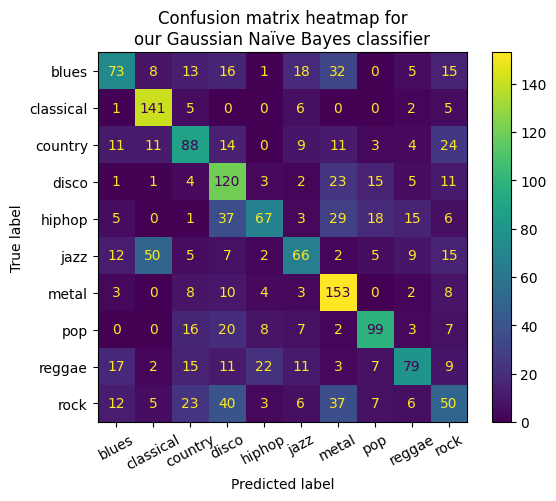

In [7]:
gaussian_nb_classifier = GaussianNaïveBayesClassifier()

gaussian_nb_classifier.fit(X_train, y_train_encoded)

y_pred_train = gaussian_nb_classifier.predict(X_train)
y_pred_train_decoded = label_encoder.inverse_transform(y_pred_train)

print("Accuracy on train set:", accuracy_score(y_train, y_pred_train_decoded))

y_pred = gaussian_nb_classifier.predict(X_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print("Accuracy on test set:", accuracy_score(y_test, y_pred_decoded))

class_report = classification_report(y_test, y_pred_decoded)
print("\nClassification Report for our Gaussian Naïve Bayes classifier:\n")
print(class_report)

cm = confusion_matrix(y_test, y_pred_decoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots()
ax.set_title("Confusion matrix heatmap for\nour Gaussian Naïve Bayes classifier")
disp.plot(ax=ax)
plt.xticks(rotation=28)
plt.show()

Now let's test sklearn's implementation performance:

Classification Report for sklearn's Gaussian Naïve Bayes classifier:

              precision    recall  f1-score   support

       blues       0.54      0.40      0.46       181
   classical       0.65      0.88      0.75       160
     country       0.49      0.50      0.50       175
       disco       0.44      0.65      0.52       185
      hiphop       0.61      0.37      0.46       181
        jazz       0.50      0.38      0.43       173
       metal       0.52      0.80      0.63       191
         pop       0.64      0.61      0.63       162
      reggae       0.61      0.45      0.52       176
        rock       0.33      0.26      0.29       189

    accuracy                           0.53      1773
   macro avg       0.53      0.53      0.52      1773
weighted avg       0.53      0.53      0.52      1773



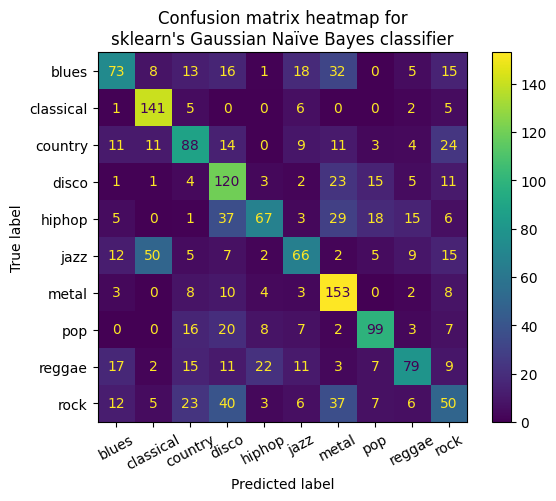

In [10]:
from sklearn.naive_bayes import GaussianNB

sk_gaussian_nb_classifier = GaussianNB()
sk_gaussian_nb_classifier.fit(X_train, y_train)

sk_y_pred = sk_gaussian_nb_classifier.predict(X_test)

sclass_report = classification_report(y_test, sk_y_pred)
print("Classification Report for sklearn's Gaussian Naïve Bayes classifier:\n")
print(class_report)

cm = confusion_matrix(y_test, y_pred_decoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots()
ax.set_title("Confusion matrix heatmap for\nsklearn's Gaussian Naïve Bayes classifier")
disp.plot(ax=ax)
plt.xticks(rotation=28)
plt.show()

We notice that the results are exactly the same! Indeed we can test this succinctly:

In [11]:
(sk_y_pred == y_pred_decoded).all()

True

Therefore we conclude that the two implementations are isomorphic.